# Code for Dog Simulation

This code run the dog simulation

In [260]:
# -*- coding: utf-8 -*-

"""Copyright 2015 Roger R Labbe Jr.


Code supporting the book

Kalman and Bayesian Filters in Python
https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python


This is licensed under an MIT license. See the LICENSE.txt file
for more information.
"""

from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import code.book_plots as bp
import filterpy.stats as stats
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import randn, seed


def plot_dog_track(xs, dog, measurement_var, process_var):
    N = len(xs)
    bp.plot_track(dog)
    bp.plot_measurements(xs, label='Sensor')
    bp.set_labels('variance = {}, process variance = {}'.format(
              measurement_var, process_var), 'time', 'pos')
    plt.ylim([0, N])
    bp.show_legend()
    plt.show()


def print_gh(predict, update, z):
    predict_template = '{: 7.3f} {: 8.3f}'
    update_template = '{:.3f}\t{: 7.3f} {: 7.3f}'

    print(predict_template.format(predict[0], predict[1]),end='\t')
    print(update_template.format(z, update[0], update[1]))


def print_variance(positions):
    for i in range(0, len(positions), 5):
        print('\t{:.4f} {:.4f} {:.4f} {:.4f} {:.4f}'.format(
                *[v[1] for v in positions[i:i+5]]))



def gaussian_vs_histogram():

    seed(15)
    xs = np.arange(0, 20, 0.1)
    ys = np.array([stats.gaussian(x-10, 0, 2) for x in xs])
    bar_ys = abs(ys + randn(len(xs)) * stats.gaussian(xs-10, 0, 10)/2)
    plt.gca().bar(xs[::5]-.25, bar_ys[::5], width=0.5, color='g')
    plt.plot(xs, ys, lw=3, color='k')
    plt.xlim(5, 15)


class DogSimulation(object):
    def __init__(self, x0=0, velocity=1,
                 measurement_var=0.0,
                 process_var=0.0):
        """ x0 : initial position
            velocity: (+=right, -=left)
            measurement_var: variance in measurement m^2
            process_var: variance in process (m/s)^2
        """
        self.x = x0
        self.velocity = velocity
        self.meas_std = sqrt(measurement_var)
        self.process_std = sqrt(process_var)

    def move(self, dt=1.0):
        """Compute new position of the dog in dt seconds."""
        dx = self.velocity + randn()*self.process_std
        self.x += dx * dt

    def sense_position(self):
        """ Returns measurement of new position in meters."""
        measurement = self.x + randn()*self.meas_std
        return measurement

    def move_and_sense(self):
        """ Move dog, and return measurement of new position in meters"""
        self.move()
        return self.sense_position()


In [261]:
def gaussian_multiply(g1, g2):
    mu1, var1 = g1
    mu2, var2 = g2
    mean = (var1*mu2 + var2*mu1) / (var1 + var2)
    variance = (var1 * var2) / (var1 + var2)
    return (mean, variance)

def update(prior, likelihood):
    posterior = gaussian_multiply(likelihood, prior)
    return posterior

def predict(pos, movement):
    return (pos[0] + movement[0], pos[1] + movement[1])

# Kalman Filter Implementation (1D)

In [262]:
np.random.seed(13)

process_var = 1. # variance in the dog's movement
sensor_var = 2. # variance in the sensor

x = (0., 400.)  # dog's position, N(0, 20**2)
velocity = 1
dt = 1. # time step in seconds
process_model = (velocity*dt, process_var) 
  
# simulate dog and get measurements
dog = DogSimulation(
    x0=x[0], 
    velocity=process_model[0], 
    measurement_var=sensor_var, 
    process_var=process_model[1])

# create list of measurements
zs = [dog.move_and_sense() for _ in range(10)]

print('PREDICT\t\t\tUPDATE')
print('     x      var\t\t  z\t    x      var')

# run the filter
xs, predictions = [], []
for z in zs:
    # perform Kalman filter on measurement z
    prior = predict(x, process_model)
    likelihood = (z, sensor_var)
    x = update(prior, likelihood)

    # save results
    predictions.append(prior[0])
    xs.append(x[0])
    print_gh(prior, x, z)

print()
print('final estimate:        {:10.3f}'.format(x[0]))
print('actual final position: {:10.3f}'.format(dog.x))


PREDICT			UPDATE
     x      var		  z	    x      var
  1.000  401.000	1.354	  1.352   1.990
  2.352    2.990	1.882	  2.070   1.198
  3.070    2.198	4.341	  3.736   1.047
  4.736    2.047	7.156	  5.960   1.012
  6.960    2.012	6.939	  6.949   1.003
  7.949    2.003	6.844	  7.396   1.001
  8.396    2.001	9.847	  9.122   1.000
 10.122    2.000	12.553	 11.338   1.000
 12.338    2.000	16.273	 14.305   1.000
 15.305    2.000	14.800	 15.053   1.000

final estimate:            15.053
actual final position:     14.838


# Kalman Filter Implementation (xD)

In [263]:
from filterpy.kalman import predict, update

In [264]:
import math
import numpy as np
from numpy.random import randn

def compute_dog_data(z_var, process_var, count=1, dt=1.):
    "returns track, measurements 1D ndarrays"
    x, vel = 0., 1.
    z_std = math.sqrt(z_var) 
    p_std = math.sqrt(process_var)
    xs, zs = [], []
    for _ in range(count):
        v = vel + (randn() * p_std * dt)
        x += v*dt        
        xs.append(x)
        zs.append(x + randn() * z_std)        
    return np.array(xs), np.array(zs)

# Thinking of Adaptation for Ocean One

For the Ocean One robot:


Input:
- Accelerometer (IMU)
- Velocity (Doppler Velocity Log)
- Camera (Optical Flow)
- Input of propeller and orientation of propeller??? Redundant with DVL? Sensor fusion to get a better estimation of the speed?

Expected output:
- position of the robot on the horizontal axis



Our state from sensors (x):
- velocity
- acceleration


# Thoughts

Can we get the input of the propeller and its orientation or do you think it is going to be redundant with the accelerometer (IMU) ?

Question: Change of direction VS Hitting a wall? How the IMU react? 

—> Drift cause to grow the error following a square rule over time.
—> magnetometers to reduce a lot the drift!

—> What is the expected accuracy?


Kalman Filter OR particle filter


—> Use of knowledge (ex: displacement in the water when no propeller are used, voir 8.2 Cambridge paper)


Problem: Current
—> What is very difficult to deduct, is that we will be able to have the relative position in the water, knowing the fact there will be current under water. We might want to have a map of the submarine current to add it as input to the Kalman Filter.



« Context-Aided Sensor Fusion for Enhanced Urban Navigation » - set the urban navigation to underwater navigation


Would the ground positioning system we will Use with Montreal, is updating the ground position of the robot at a particular frequency. SO then we will have to estimate the positioning of the robot between two measures? Problem stays the current we don’t know for underwater which will impact the position. 

—> Underwater courant can be tackled by knowing the value of IMU and input of propeller!



—> We could try to detect when the robot hi the wall VS change of direction VS subject to strong curant.

# Notes Kalman Filter



Convert State to Measurement --> Example: State Tenperature, Measurement Volt (AND NOT Measurement to State, not invertible)

Work in measurement Space

Measurement: z

State: x

Residual: y --> Kalman: y=z-H*x_barre

(H is the Measurement function: to convert state to measurement, x_barre is the prior)

<img src="./figs/residual_chart_with_h.png">

Pos and movement are Gaussian tuples:

In [265]:
def predict(pos, movement):
    return (pos[0] + movement[0], pos[1] + movement[1])

In our case:  z=[$\dot z$, $\ddot z$] (IMU, DVL: acceleration, velocity)

In our case: $\mathbf x$ is the position --> x=[x] --> x is a hidden variables - inferred from the observed variables (z variables)

P is the covariance Matrix of $\mathbf x$



# Steps for Kalman Filter

## Step to do for prediction:
    
1) Get the data from sensors -> store them into z variable. Will have to go through each measurements one after an other. Challenge, check the frequency at which each sensor is sending feedback. To go further: See if we could use each different epoch per sensor to do the Kalman

2) Design State Covariance. Use the data we have online to generate the first covariance $\sigma^2$. Then after each additional measurement, the covariance will be updated. The covariance matrix is P and is of the dimension of nxn, n being the number of variable in our state.

3) Design the process model. Used to predict the state after a discrete amount of time. In our case. Using acceleration, integration 2 times and velocity integrating one time. --> $ x = 0.5 a \Delta t^2 + v \Delta t + x_0$

$$\begin{aligned}
\begin{bmatrix}\bar x \\ \bar{\dot x}\\ \bar{\ddot x} \\ \bar y \\ \bar{\dot y}\\ \bar{\ddot y} \end{bmatrix} &= \begin{bmatrix}1&\Delta t &0.5\Delta t^2 &0&0&0 \\ 0&1&0&0&0&0 \\ 0&0&1&0&0&0 \\ 0&0&0&1&\Delta t &0.5\Delta t^2 \\ 0&0&0&0&1&0 \\0&0&0&0&0&1 \end{bmatrix}  \begin{bmatrix}x \\ \dot x \\ \ddot x \\ y \\ \dot y \\ \ddot y \end{bmatrix}\\
\mathbf{\bar x} &= \mathbf{Fx}
\end{aligned}$$

Dim of prior and posterio should be the same, below is not usable.

$$\begin{aligned}
\begin{bmatrix}\bar x \\ \bar y \end{bmatrix} &= \begin{bmatrix}1&\Delta t &0.5\Delta t^2 &0&0&0 \\ 0&0&0&1&\Delta t &0.5\Delta t^2 \end{bmatrix}  \begin{bmatrix}x \\ \dot x \\ \ddot x \\ y \\ \dot y \\ \ddot y \end{bmatrix}\\
\mathbf{\bar x} &= \mathbf{Fx}
\end{aligned}$$

from filterpy.kalman import predict --> calculate the state knowing a deltaT input

In [266]:
from filterpy.kalman import predict # calculate the state knowing a deltaT input
dt = 0.1
x = np.array([10.0, 4.5])
P = np.diag([500, 49])
F = np.array([[1, dt], [0, 1]])

# Q is the process noise
x, P = predict(x=x, P=P, F=F, Q=0)
print('x =', x)

x = [ 10.4  4.5]


4) Design process noise: White noise means the mean is 0. So noise will only impact variance --> P in a way that P=P+Q (Q being the noise covariance matrix). We create a covariance matrix Q which will take care the noise. For kinematic we will use Q_discrete_white_noise

In [267]:
from filterpy.common import Q_discrete_white_noise
#We have to put the variance we have from point 2.
Q = Q_discrete_white_noise(dim=2, dt=1., var=2.35)
print(Q)

[[ 0.588  1.18]
 [ 1.18  2.35]]


5) Design the control function. We can add the control function to our Kalman Filter. We will use the control function of our propeller and the direction of our propeller to put as input. B and u will be the variables that will repreent the control fucntion. $$\Delta\mathbf x = \mathbf{Bu}$$

In [268]:
B=0
u=0
x, P = predict(x, P, F, Q, B, u)

## UPDATE STEPS:

6) Design Measurement Function H. K being the Kalman Gain. We use H to transform the state into a measurement that is comparable to the prediction. (V with V and not V with °C). My work will be to find how to translate the motor controller input into a position and optical flow into a position. <img src="./figs/residual_chart_with_h.png">

7) Design the measurement. z are the input from sensors, R is the covariance matrix of the error on the sensor. Beware, it very often doesn't fit a gaussian model.

8) Prediction Equation

$$
\begin{aligned}
\text{Predict Step}\\
\mathbf{\bar x} &= \mathbf{F x} + \mathbf{B u} \\
\mathbf{\bar P} &= \mathbf{FP{F}}^\mathsf T + \mathbf Q \\
\\
\text{Update Step}\\
\textbf{S} &= \mathbf{H\bar PH}^\mathsf T + \mathbf R \\
\mathbf K &= \mathbf{\bar PH}^\mathsf T \mathbf{S}^{-1} \\
\textbf{y} &= \mathbf z - \mathbf{H \bar x} \\
\mathbf x &=\mathbf{\bar x} +\mathbf{K\textbf{y}} \\
\mathbf P &= (\mathbf{I}-\mathbf{KH})\mathbf{\bar P}
\end{aligned}
$$

# Kalman Filter Implementation

In [269]:
#format the book
%matplotlib inline
from __future__ import division, print_function
load_style()

Data Generator

(<matplotlib.collections.PathCollection at 0x113b01c18>,)

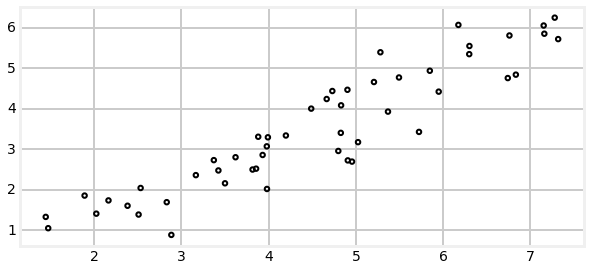

In [272]:
###############
# Sensors Data Generator :
###############
from numpy.random import randn
import copy
class PosSensor1(object):
    def __init__(self, acc=(0,0), vel=(0, 0), noise_std=1.,dt=1):
        self.vel = [vel[0], vel[1]]
        self.noise_std = noise_std
        self.dt= dt
        self.acc = [acc[0], acc[1]]
        
    def read(self):
        self.vel[0]+=self.acc[0]*dt
        self.vel[1]+=self.acc[1]*dt
        returned=np.zeros((4,1))
        returned[0]=self.vel[0] + randn() * self.noise_std
        returned[1]=self.acc[0] + randn() * self.noise_std
        returned[2]=self.vel[1] + randn() * self.noise_std
        returned[3]=self.acc[1] + randn() * self.noise_std
        
        return returned

    
#TEST OF CLASS POSSENSOR1!
import matplotlib.pyplot as plt
import numpy as np
import code.book_plots as bp
acc, vel = (1, 1), (2, 1)
sensor = PosSensor1(acc, vel, noise_std=0.5)
ps = np.array([sensor.read() for _ in range(50)])
bp.plot_measurements(ps[:, 0], ps[:, 2])

Kalman Filter

In [285]:
from filterpy.kalman import KalmanFilter
from scipy.linalg import block_diag
from filterpy.common import Q_discrete_white_noise

##############################
# Sensors Caracteristics:
##############################

#Sensor 1: DVL - axis x
meanValueS1x=1    #Test Value
varValueS1x=1    #Test Value

#Sensor 1: DVL - axis y
meanValueS1y=1    #Test Value
varValueS1y=1    #Test Value

#Sensor 2: IMU - axis x
meanValueS2x=1    #Test Value
varValueS2x=1    #Test Value

#Sensor 2: IMU - axis y
meanValueS2y=1    #Test Value
varValueS2y=1    #Test Value

#epoch of sensors
epochS1=1    #Test Value
epochS2=1    #Test Value
dt=epochS1   #TEMPORARY COMMENT: used in transition of having the right epoch of each sensor


##############################
# Kalman Filter Dimension
##############################

#Filter dimension: Here we want only 2 outputs (position x and position y) but need 6 inputs 
#to calculate our prediction using the State Transition Function : 0.5*a*dt^2+v*dt+x
dim_x=6

#Sensors output dimension: Here with DVL and IMU we use acceleration and velocity on 2 axis which results in dim 4.
dim_z=4


##############################
# Parameters to design for the Kalman Filter:
##############################

#Filter Initialization
horizontalPosFilter=KalmanFilter(dim_x,dim_z)

#F: State Transition Matrix --> using the Newton's equation: x(t+1)=0.5*a*dt^2+v*dt+x(t)
horizontalPosFilter.F=np.array([[1,dt,0.5*dt,0,0,0],
                                [0,1,dt,0,0,0],
                                [0,0,1,0,0,0],
                                [0,0,0,1,dt,0.5*dt],
                                [0,0,0,0,1,dt],
                                [0,0,0,0,0,1]])

#Q: White noise Covariance Matrix
q = Q_discrete_white_noise(dim=3, dt=dt, var=0.001)  #Var to be modified designed... HOW? Have no clue...
horizontalPosFilter.Q = block_diag(q, q)

# Implementation of the control transition matrix
# B and u
# Question: Do we add this part to our Kalman Filter since the control might be redundant to the sensors value? Yes we do.


# H is the measurement function (4x6) (each sensor output x each Filter output) Z --> input DVL x, input IMU x, input DVL y, input IMU y). 
# This matrix will have to be changed if we have to change some units. All are in meters and seconds.
horizontalPosFilter.H=np.array([[0,1,0,0,0,0],
                                [0,0,1,0,0,0],
                                [0,0,0,0,1,0],
                                [0,0,0,0,0,1]])

# R: Noise Measurement Matrix (DVLx, IMUx, DVLy, IMUy): covariances
# add covariance, if some sensors have some correlation: DVL x and y have correlation? YES!! Same for IMU.
horizontalPosFilter.R=np.array([[varValueS1x,0,0,0],
                                [0,varValueS2x,0,0],
                                [0,0,varValueS1y,0],
                                [0,0,0,varValueS2y]])

horizontalPosFilter.Q=0

# Initial Conditions
data_var=0.5 #TO CHANGE 
horizontalPosFilter.x=np.array([[0,0,0,0,0,0]]).T
horizontalPosFilter.P=np.eye(dim_x)*data_var #Replace with the data variance of our testing set! for each sensor/direction

(0, 50)

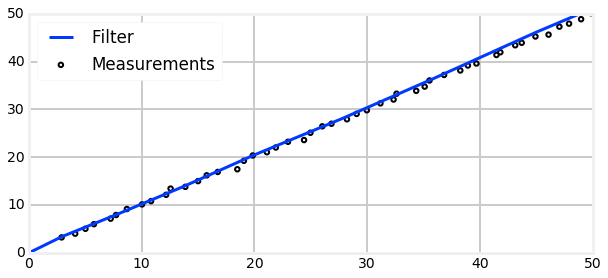

In [286]:
acc,vel=(1,1),(2,2)
std_data=0.25
sensor=PosSensor1(acc,vel,std_data)

measure_x=[]
predict_x=[]

for i in range(0,50):
    # Predict
    horizontalPosFilter.predict(F=horizontalPosFilter.F,Q=horizontalPosFilter.Q)
    predict_x.append(horizontalPosFilter.x)
    
    # Update New Measure
    measure=sensor.read()
    horizontalPosFilter.update(z=measure,R=horizontalPosFilter.R,H=horizontalPosFilter.H)
    measure_x.append(measure)

measure_x = np.asarray(measure_x)
predict_x = np.asarray(predict_x)
    
bp.plot_filter(predict_x[:,0], predict_x[:,3])
bp.plot_measurements(measure_x[:,0], measure_x[:,2])
plt.legend(loc=2)
plt.xlim((0, 50))
plt.ylim((0, 50))

In [276]:
### OPTIONNAL: MANUAL EQUATION WITHOUT THE LIBRARY FILTERPY
# http://www.cs.unc.edu/~tracker/media/pdf/SIGGRAPH2001_CoursePack_08.pdf

##############################
#Update Time Function
##############################

for i in range(50):
    #Update x
    horizontalPosFilter.x=np.dot(horizontalPosFilter.x.T,horizontalPosFilter.F).T
    #horizontalPosFilter.x+=horizontalPosFilter.B*horizontalPosFilter.u #TO UNCOMMENT IF WE ADD CONTROL INPUTS

    #Update P
    horizontalPosFilter.P=np.dot(np.dot(horizontalPosFilter.F,horizontalPosFilter.P),horizontalPosFilter.F.T)+horizontalPosFilter.Q

##############################
#Update Measurement Function
##############################  
    #Update Filter Gain K
    #...

